# CS 410 Project

Name: Rustom Ichhaporia

netID: rustomi2

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import helper
import nltk
import string
import re
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.matutils import corpus2csc
from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import phonenumbers
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
sns.set()

Uncomment and run the cell below to generate data from your own `chat.db` file.

In [2]:
# # Path to iMessage database on MacOS
# db_path = '/Users/rustomichhaporia/Library/Messages/chat.db'
# data_raw = helper.read_messages(db_path, n=None)
# # Convert list of tuples to dataframe
# df = pd.DataFrame.from_records(data_raw, columns =['row_id', 'date', 'body', 'phone_number', 'is_from_me', 'cache_roomname', 'group_chat_name'])
# df = df.drop(['row_id', 'cache_roomname', 'group_chat_name'], axis=1)
# df = df.rename(columns={'date': 'timestamp', 'body': 'message'})

# # Pickle data for faster access later 
# df.to_pickle('imessage.pkl')

In [3]:
df = pd.read_pickle('imessage.pkl')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Remove messages from invalid phone number addresses. For the purposes of joining with my contacts, I ignored messages from email addresses and non-phone number addresses, but this can be changed to accomodate those addresses.
df = df[~df.phone_number.str.contains('@')]
df = df[~df.phone_number.str.contains('urn')]
df = df[df.phone_number.str.len() > 7]

df = df.drop_duplicates()

In [4]:
# # Please change the following line and replace it with the path to your contacts database on MacOS. It should be the folder with the most storage in the `.../Sources/` folder.
# contacts_folder = 'BFD08200-6674-4373-8DDB-8DB8D7FB1A7D'
# contacts_path = '/Users/rustomichhaporia/Library/Application Support/AddressBook/Sources/' + contacts_folder + '/AddressBook-v22.abcddb'
# conn = sqlite3.connect(contacts_path)
# cursor = conn.cursor()

# query = '''
# select ZABCDPHONENUMBER.ZFULLNUMBER, ZFIRSTNAME || ' ' || ZLASTNAME
# from ZABCDPHONENUMBER
# left join ZABCDRECORD
# on ZABCDPHONENUMBER.ZOWNER = ZABCDRECORD.Z_PK
# '''

# contacts = pd.DataFrame(cursor.execute(query).fetchall(), columns=['phone_number', 'name'])

# def format_number(x):
#     try:
#         return phonenumbers.format_number(phonenumbers.parse(x, 'US'), num_format=phonenumbers.PhoneNumberFormat.INTERNATIONAL)
#     except:
#         return x
    
# contacts['phone_number'] = contacts.phone_number.apply(lambda x: format_number(x))
# contacts.to_pickle('contacts.pkl')

contacts = pd.read_pickle('contacts.pkl')
df['phone_number'] = df.phone_number.apply(lambda x: format_number(x))
df = df.merge(contacts, how='left', left_on='phone_number', right_on='phone_number')

In [5]:
# # Adjust the number below to change the number of top contacts to include in the analysis. 
# n_top_numbers = 50
# included_numbers = pd.Series(df.groupby('phone_number').count().sort_values(by='message', ascending=False).head(n_top_numbers).index)
# df = df[df['phone_number'].isin(included_numbers)]

In [9]:
# import os
# import json
# # Change this to the path to your Facebook data
# # It should contain at least one folder labeled your_activity_across_facebook... with an inbox folder inside
# rootdir = './facebook-data'
# # Change this to your name on Facebook
# my_facebook_name = 'Rustom Ichhaporia'

# facebook_df = pd.DataFrame()

# for subdir, dirs, files in os.walk(rootdir):
#     for file in files:
#         if file.startswith('message') and file.endswith('.json'):
#             if 'inbox' not in subdir:
#                 continue
#             temp_path = os.path.join(subdir, file)
#             temp = json.load(open(temp_path))

#             if len(temp['participants']) > 2 or temp['title'] == '': 
#                 continue
            
#             temp_df = pd.DataFrame(temp['messages']).rename(columns={'sender_name': 'name', 'timestamp_ms': 'timestamp', 'content': 'message'})
#             if 'message' not in temp_df.columns:
#                 continue
#             temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'], unit='ms')
#             temp_df['is_from_me'] = temp_df.name == my_facebook_name
#             temp_df = temp_df[['timestamp', 'message', 'name', 'is_from_me']]
#             temp_df['phone_number'] = ''
#             temp_df['name'] = temp['title']
#             facebook_df = pd.concat([facebook_df, temp_df]).reset_index(drop=True)

# facebook_df = facebook_df.drop_duplicates()
# facebook_df = facebook_df[facebook_df.message != '']
# facebook_df.to_pickle('facebook.pkl')
# facebook_df = pd.read_pickle('facebook.pkl')

# df = pd.concat([df, facebook_df]).reset_index(drop=True).drop_duplicates()
# df.to_pickle('all.pkl')

df = pd.read_pickle('all.pkl')

In [13]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# Optional preprocessing function for text data
# lemmatizer = nltk.stem.WordNetLemmatizer()
# stopwords = nltk.corpus.stopwords.words('english')
# def preprocess(text):
#     # Tokenize words
#     tokens = nltk.word_tokenize(text)
#     # Convert to lower case
#     tokens = [word.lower() for word in tokens]
#     # Remove punctuation and stopwords
#     tokens = [token for token in tokens if token not in string.punctuation and token not in stopwords]
#     # Remove URLS
#     url_pattern = r"(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"
#     tokens = [token for token in tokens if not re.match(url_pattern, token)]
#     # Lemmatize words
#     tokens = [lemmatizer.lemmatize(token) for token in tokens]
#     return ' '.join(tokens)

# df['message'] = df.message.apply(lambda x: preprocess(x))

In [20]:
df['message_length'] = df.message.str.len()
analyzer = SentimentIntensityAnalyzer()
df['compound_sentiment'] = df.message.astype(str).apply(lambda x: analyzer.polarity_scores(x)['compound'])

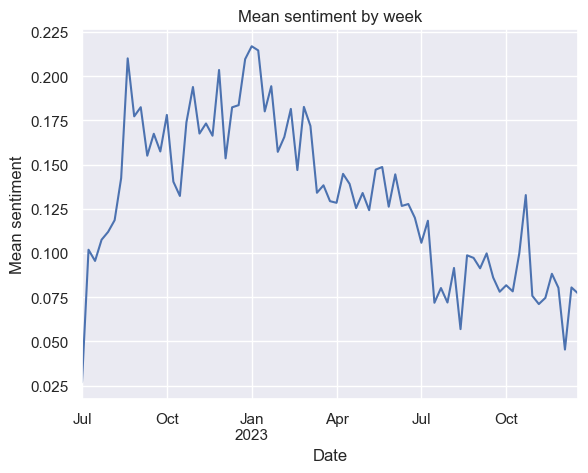

In [ ]:
df.groupby(pd.Grouper(freq='W', key='timestamp')).compound_sentiment.mean().plot()
plt.xlabel('Date')
plt.ylabel('Mean sentiment')
plt.title('Mean sentiment by week')
plt.show()

<AxesSubplot: xlabel='compound_sentiment', ylabel='Density'>

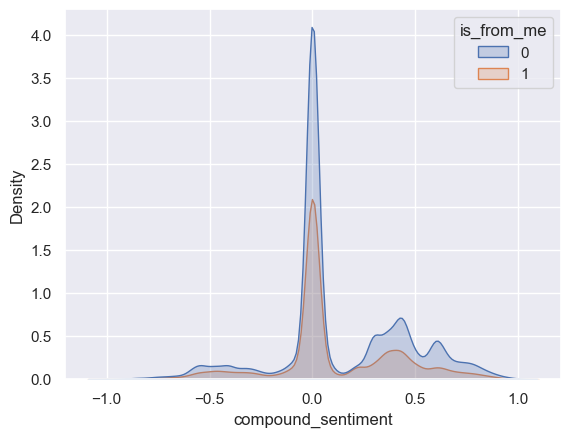

In [ ]:
sns.kdeplot(x='compound_sentiment', hue='is_from_me', fill=True, data=df)

In [ ]:
name_groupby = df.groupby('name').agg(num_messages=('compound_sentiment', 'size'), mean_compound_sentiment=('compound_sentiment', 'mean'), mean_message_length=('message_length', 'mean'), proportion_from_me=('is_from_me', 'mean')).reset_index()

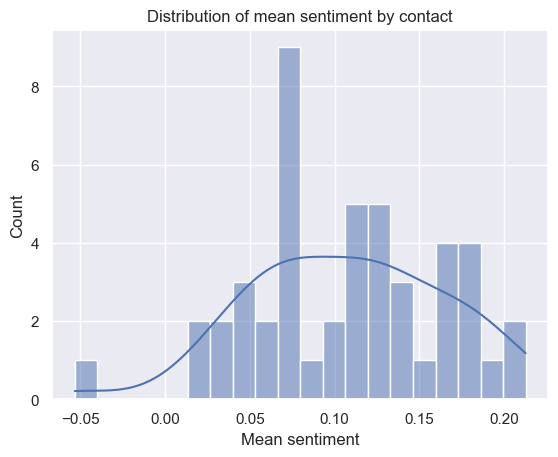

In [ ]:
sns.histplot(name_groupby.mean_compound_sentiment, kde=True, bins=20)
plt.xlabel('Mean sentiment')
plt.ylabel('Count')
plt.title('Distribution of mean sentiment by contact')
plt.show()

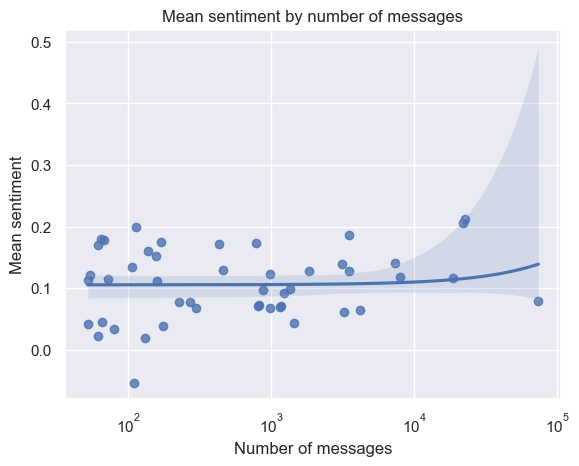

In [ ]:
sns.regplot(x='num_messages', y='mean_compound_sentiment', data=name_groupby)
plt.xscale('log')
plt.xlabel('Number of messages')
plt.ylabel('Mean sentiment')
plt.title('Mean sentiment by number of messages')
plt.show()

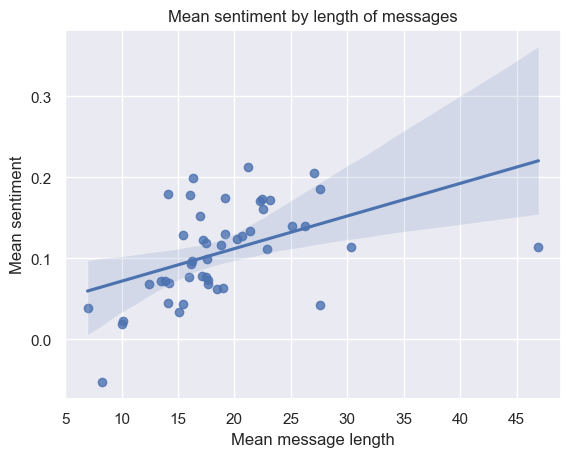

In [ ]:
sns.regplot(x='mean_message_length', y='mean_compound_sentiment', data=name_groupby)
plt.xlabel('Mean message length')
plt.ylabel('Mean sentiment')
plt.title('Mean sentiment by length of messages')
plt.show()

<AxesSubplot: xlabel='proportion_from_me', ylabel='mean_compound_sentiment'>

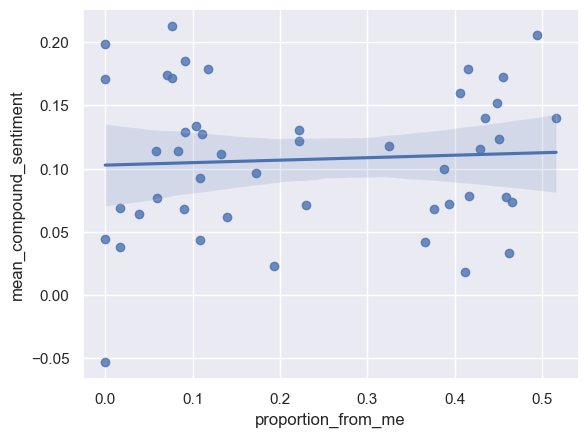

In [ ]:
sns.regplot(x='proportion_from_me', y='mean_compound_sentiment', data=name_groupby)

<AxesSubplot: xlabel='proportion_from_me', ylabel='mean_message_length'>

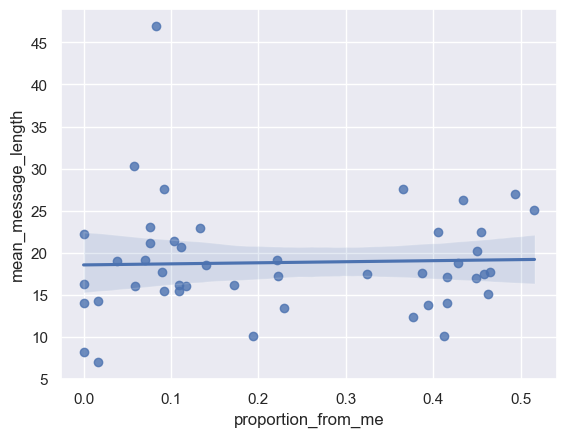

In [ ]:
sns.regplot(x='proportion_from_me', y='mean_message_length', data=name_groupby)

In [ ]:
import os
import json
# Change this to the path to your Facebook data
# It should contain at least one folder labeled your_activity_across_facebook... with an inbox folder inside
rootdir = './facebook-data'
# Change this to your name on Facebook
my_facebook_name = 'Rustom Ichhaporia'

facebook_df = pd.DataFrame()

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if file.startswith('message') and file.endswith('.json'):
            if 'inbox' not in subdir:
                continue
            temp_path = os.path.join(subdir, file)
            temp = json.load(open(temp_path))

            if len(temp['participants']) > 2 or temp['title'] == '': 
                continue
            
            temp_df = pd.DataFrame(temp['messages']).rename(columns={'sender_name': 'name', 'timestamp_ms': 'timestamp', 'content': 'message'})
            if 'message' not in temp_df.columns:
                continue
            temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'], unit='ms')
            temp_df['is_from_me'] = temp_df.name == my_facebook_name
            temp_df = temp_df[['timestamp', 'message', 'name', 'is_from_me']]
            temp_df['phone_number'] = ''
            temp_df['name'] = temp['title']
            facebook_df = pd.concat([facebook_df, temp_df]).reset_index(drop=True)

df = pd.concat([df, facebook_df]).reset_index(drop=True).drop_duplicates()

,timestamp,message,name,is_from_me,phone_number
0,2017-10-15 01:02:46.238,What?,Rebecca Xun,1,
1,2017-10-15 00:01:11.446,Hey rustom u good boy,Rebecca Xun,0,
2,2017-10-09 23:26:59.409,Yeah got it,Rebecca Xun,1,
3,2017-10-09 23:26:01.390,"hmm, ok please let him know asap and let him k...",Rebecca Xun,0,
4,2017-10-09 23:25:18.525,Aryan and I haven't communicated much at all l...,Rebecca Xun,1,
...,...,...,...,...,...
707842,2023-12-16 01:59:53.000,but still not enough for you to go out with me,Breanna Yang,1,+1 630-338-7188
707844,2023-12-16 02:00:20.000,erm uh no yeah i no um yeah let’s go out,Breanna Yang,0,+1 630-338-7188
707846,2023-12-16 02:00:40.000,that’s why i suggested a meal,Breanna Yang,0,+1 630-338-7188
707848,2023-12-16 02:00:50.000,bc i wanna go out w u dummy,Breanna Yang,0,+1 630-338-7188


In [ ]:
facebook_df.shape

(519594, 5)

In [ ]:
facebook_df.shape

(519594, 5)

In [ ]:
facebook_df.isna().sum()

timestamp         0
message         917
name              0
is_from_me        0
phone_number      0
dtype: int64

In [ ]:
temp_path = './facebook-data/your_activity_across_facebook 2/messages/filtered_threads/nickelodeonallstarbrawlclub2021_2441138012643566/message_1.json'
temp = json.load(open(temp_path))['messages']
temp_df = pd.DataFrame(temp).rename(columns={'sender_name': 'name', 'timestamp_ms': 'timestamp', 'content': 'message'})
temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'], unit='ms')
temp_df['is_from_me'] = temp_df.name == my_facebook_name
temp_df = temp_df[['timestamp', 'message', 'name', 'is_from_me']]
temp_df['phone_number'] = ''
facebook_df = pd.concat([facebook_df, temp_df]).reset_index(drop=True)

,timestamp,message,phone_number,is_from_me,name
0,2022-06-30 20:00:40.000,Cum,+1 217-898-6544,0,Daniel Lee
1,2022-06-30 20:00:57.000,hi who's this ☺️,+1 217-898-6544,1,Daniel Lee
2,2022-06-30 20:01:03.000,Daniel,+1 217-898-6544,0,Daniel Lee
3,2022-06-30 20:01:06.000,Is this rustom,+1 217-898-6544,0,Daniel Lee
4,2022-06-30 20:01:23.000,no this is the krusty krab,+1 217-898-6544,1,Daniel Lee
...,...,...,...,...,...
195166,2019-09-04 04:14:21.435,Me and some friends were gonna go to my room a...,,0,Austin McDonald
195167,2019-09-04 04:13:31.233,just saying,,0,Sebastian Ramos
195168,2019-09-04 04:13:29.333,yall should have an event to watch the direct ...,,0,Sebastian Ramos
195169,2019-09-04 04:12:53.698,so youre a tough guy,,0,Sebastian Ramos


In [ ]:
new.reset_index()

,index,timestamp,message,phone_number,is_from_me,name
0,0,2022-06-30 20:00:40.000,Cum,+1 217-898-6544,0,Daniel Lee
1,1,2022-06-30 20:00:57.000,hi who's this ☺️,+1 217-898-6544,1,Daniel Lee
2,2,2022-06-30 20:01:03.000,Daniel,+1 217-898-6544,0,Daniel Lee
3,3,2022-06-30 20:01:06.000,Is this rustom,+1 217-898-6544,0,Daniel Lee
4,4,2022-06-30 20:01:23.000,no this is the krusty krab,+1 217-898-6544,1,Daniel Lee
...,...,...,...,...,...,...
195166,6908,2019-09-04 04:14:21.435,Me and some friends were gonna go to my room a...,,0,Austin McDonald
195167,6909,2019-09-04 04:13:31.233,just saying,,0,Sebastian Ramos
195168,6910,2019-09-04 04:13:29.333,yall should have an event to watch the direct ...,,0,Sebastian Ramos
195169,6911,2019-09-04 04:12:53.698,so youre a tough guy,,0,Sebastian Ramos


In [ ]:
new[new.timestamp == '2022-08-12 23:59:29']

,timestamp,message,phone_number,is_from_me,name
6912,2022-08-12 23:59:29,Tanta at 9:30,+1 734-892-7076,0,Ryan Gudal


In [ ]:
new[new.timestamp == '2019-09-04 04:12:42.068']

,timestamp,message,phone_number,is_from_me,name
6912,2019-09-04 04:12:42.068,"You think you some kind of wise guy, huh?",,0,Chas Schreiber


In [ ]:
new.iloc[6912]

timestamp       2022-08-12 23:59:29
message               Tanta at 9:30
phone_number        +1 734-892-7076
is_from_me                        0
name                     Ryan Gudal
Name: 6912, dtype: object

In [ ]:
temp_df.reset_in

,timestamp,message,name,is_from_me,phone_number
0,2023-01-01 06:13:05.399,Happy tears of the kingdom year ex-multiverses...,Sebastian Ramos,False,
1,2023-01-01 06:12:33.143,HAPPY FUCKING NEW YEAR @Philip Paulson,Chas Schreiber,False,
2,2023-01-01 06:11:54.795,NaN,Philip Paulson,False,
3,2022-07-14 17:14:44.177,Anybody wanna see a musical near IMSA? https:/...,Philip Paulson,False,
4,2022-05-14 07:04:52.136,Yes,Austin McDonald,False,
...,...,...,...,...,...
6908,2019-09-04 04:14:21.435,Me and some friends were gonna go to my room a...,Austin McDonald,False,
6909,2019-09-04 04:13:31.233,just saying,Sebastian Ramos,False,
6910,2019-09-04 04:13:29.333,yall should have an event to watch the direct ...,Sebastian Ramos,False,
6911,2019-09-04 04:12:53.698,so youre a tough guy,Sebastian Ramos,False,


In [ ]:
df

,timestamp,message,phone_number,is_from_me,name
0,2022-06-30 20:00:40,Cum,+1 217-898-6544,0,Daniel Lee
1,2022-06-30 20:00:57,hi who's this ☺️,+1 217-898-6544,1,Daniel Lee
2,2022-06-30 20:01:03,Daniel,+1 217-898-6544,0,Daniel Lee
3,2022-06-30 20:01:06,Is this rustom,+1 217-898-6544,0,Daniel Lee
4,2022-06-30 20:01:23,no this is the krusty krab,+1 217-898-6544,1,Daniel Lee
...,...,...,...,...,...
188253,2023-12-16 02:00:40,that’s why i suggested a meal,+1 630-338-7188,0,Breanna Yang
188254,2023-12-16 02:00:50,bc i wanna go out w u dummy,+1 630-338-7188,0,Breanna Yang
188255,2023-12-16 02:00:50,bc i wanna go out w u dummy,+1 630-338-7188,0,Breanna Yang
188256,2023-12-16 02:14:24,it’s fine i can take a hint,+1 630-338-7188,1,Breanna Yang


In [ ]:
# Create a dictionary from the preprocessed data
dictionary = Dictionary(temp)

# Filter out words that appear in fewer than 5 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

bow_corpus = [dictionary.doc2bow(text) for text in data]

# Train the LDA model
num_topics = 5
ldamodel = LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=20, alpha='auto', eta='auto')

# Get the topics
topics = ldamodel.show_topics(num_topics=num_topics, num_words=10, log=False, formatted=False)

# Print the topics
for topic_id, topic in topics:
    print("Topic: {}".format(topic_id))
    print("Words: {}".format([word for word, _ in topic]))

Topic: 0
Words: ['okay', 'buy', 'yes', 'good', 'right', 'thank', 'next', 'need', 'god', 'day']
Topic: 1
Words: ['u', 'one', 'r', 'pick', 'want', 'home', 'time', 'make', 'fuck', 'come']
Topic: 2
Words: ['like', 'ok', 'think', 'get', 'sorry', 'know', 'even', 'would', 'let', 'tho']
Topic: 3
Words: ['ur', 'yeah', 'babe', 'paris', 'im', 'look', 'guy', 'bruh', 'hour', 'looking']
Topic: 4
Words: ['na', 'go', 'oh', 'lol', 'tower', 'gon', 'call', 'friend', 'wan', 'got']


In [ ]:
temp = data[:100000]
# Create a dictionary from the preprocessed data
dictionary = Dictionary(temp)

# Filter out words that appear in fewer than 5 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.001)

bow_corpus = [dictionary.doc2bow(text) for text in temp]

# Train the LDA model
num_topics = 15
ldamodel = LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=10, alpha='auto', eta='auto')

# Get the topics
topics = ldamodel.show_topics(num_topics=num_topics, num_words=12, log=False, formatted=False)

# Print the topics
for topic_id, topic in topics:
    print("Topic: {}".format(topic_id))
    print("Words: {}".format([word for word, _ in topic]))

Topic: 0
Words: ['waste', 'specific', 'grey', 'rate', 'mile', 'fri', 'related', 'turned', 'table', 'thurs', 'mexican', 'trading']
Topic: 1
Words: ['packing', 'stomach', 'san', 'applying', 'shop', 'block', 'score', 'excuse', 'carry', 'showing', 'egg', 'st']
Topic: 2
Words: ['totally', 'garage', 'pussy', 'doubt', 'speaker', 'teeth', 'search', 'pro', 'anniversary', 'alr', 'tn', 'fat']
Topic: 3
Words: ['letting', 'la', 'ny', 'oa', 'he', 'catch', 'mobile', 'mostly', 'service', 'dead', 'pulled', 'rock']
Topic: 4
Words: ['hotel', 'rich', 'current', 'clean', 'item', 'fucked', 'iphone', 'allowed', 'period', 'whether', 'havent', 'nose']
Topic: 5
Words: ['data', 'application', 'land', 'picked', 'diff', 'wife', 'reading', 'uh', 'mint', 'gay', 'program', 'leg']
Topic: 6
Words: ['paris', 'row', 'per', 'l', 'price', 'f', 'dick', 'e', 'mouth', 'tough', 'guitar', 'page']
Topic: 7
Words: ['pizza', 'parking', 'amazon', 'skill', 'wanting', 'worst', 'track', 'housing', 'soft', 'negotiate', 'driver', 'art']

In [ ]:
# for topic_id, topic in enumerate(ldamodel.print_topics(num_topics=num_topics, num_words=20)):
#     topic_words = " ".join([word.split("*")[1].strip() for word in topic[1].split(" + ")])
#     wordcloud = WordCloud(width=800, height=800, random_state=21, max_font_size=110).generate(topic_words)
#     plt.figure()
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.title("Topic: {}".format(topic_id))
#     plt.show()

In [ ]:
dictionary = Dictionary([tokens])


In [ ]:
bow_corpus = [dictionary.doc2bow(text) for text in tokens]
num_topics = 5
ldamodel = LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=20, alpha='auto', eta='auto')

# Get the topics
topics = ldamodel.show_topics(num_topics=num_topics, num_words=10, log=False, formatted=False)

# Print the topics
for topic_id, topic in topics:
    print("Topic: {}".format(topic_id))
    print("Words: {}".format([word for word, _ in topic]))

TypeError: doc2bow expects an array of unicode tokens on input, not a single string